<a href="https://colab.research.google.com/github/anurag-po/DiseasePredictorProject/blob/main/DiseasePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***DOWNLOADING REQUIRED MODULES***

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib gradio
!pip install kaggle gradio

In [2]:

"""Setup Kaggle credentials and download dataset"""
print("Setting up Kaggle credentials...")
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d redwankarimsony/heart-disease-data -p /content/heart-disease --unzip



Setting up Kaggle credentials...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
License(s): copyright-authors
  0% 0.00/12.4k [00:00<?, ?B/s]
100% 12.4k/12.4k [00:00<00:00, 43.0MB/s]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')


In [4]:
def load_data():
    """Load and explore the heart disease dataset"""
    print("Loading heart disease dataset...")


    try:
        df = pd.read_csv('/content/heart-disease/heart_disease_uci.csv')
    except:
        # Create sample heart disease data for demonstration

        #Specifying, The CSV File did not work on my first attempt so I made a sample data using gemini.

        np.random.seed(42)
        n_samples = 1000

        df = pd.DataFrame({
            'age': np.random.randint(30, 80, n_samples),
            'sex': np.random.choice([0, 1], n_samples),
            'cp': np.random.choice([0, 1, 2, 3], n_samples),
            'trestbps': np.random.randint(80, 200, n_samples),
            'chol': np.random.randint(150, 400, n_samples),
            'fbs': np.random.choice([0, 1], n_samples),
            'restecg': np.random.choice([0, 1, 2], n_samples),
            'thalach': np.random.randint(60, 200, n_samples),
            'exang': np.random.choice([0, 1], n_samples),
            'oldpeak': np.random.uniform(0, 6, n_samples),
            'slope': np.random.choice([0, 1, 2], n_samples),
            'ca': np.random.choice([0, 1, 2, 3], n_samples),
            'thal': np.random.choice(['normal', 'fixed', 'reversible'], n_samples),
            'num': np.random.choice([0, 1, 2, 3, 4], n_samples)
        })

    print(f"📈 Dataset shape: {df.shape}")
    print(f"📋 Columns: {list(df.columns)}")
    print(f"❌ Missing values: {df.isnull().sum().sum()}")

    return df




In [5]:
def preprocess_data(df):
    """Complete data preprocessing pipeline"""
    print("🔧 Starting data preprocessing...")

    # Handle missing values
    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    # Create visualizations
    create_visualizations(df, numeric_cols)

    # Prepare features and target
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    if 'num' in cat_cols:
        cat_cols.remove('num')

    X = df.drop('num', axis=1)
    y = (df['num'] > 0).astype(int)  # Binary: 0=no disease, 1=disease

    # One-hot encode categorical features
    X = pd.get_dummies(X, columns=cat_cols)

    print(f"✅ Features prepared: {X.shape[1]} features")
    print(f"🎯 Target distribution: {y.value_counts().to_dict()}")

    return X, y

def create_visualizations(df, numeric_cols):
    """Create and display data visualizations"""
    print("📊 Creating data visualizations...")

    # Feature distributions
    plt.figure(figsize=(15, 10))
    df[numeric_cols].hist(bins=20)
    plt.tight_layout()
    plt.suptitle('Feature Distributions', y=1.02)
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()


In [6]:
def train_models(X, y):
    """Train multiple ML models and evaluate performance"""
    print("🤖 Training machine learning models...")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }

    # Train and evaluate models
    results = {}
    best_model = None
    best_score = 0

    for name, model in models.items():
        print(f"\n🔄 Training {name}...")

        # Train model
        model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        # Track best model
        if accuracy > best_score:
            best_score = accuracy
            best_model = model

        print(f"✅ {name} - Accuracy: {accuracy:.3f}, ROC-AUC: {roc_auc:.3f}")

        # Classification report
        print(f"\n📊 Classification Report for {name}:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    # ROC curves comparison
    plot_roc_curves(results, y_test)

    # Feature importance for Random Forest
    if 'Random Forest' in results:
        plot_feature_importance(results['Random Forest']['model'], X.columns)

    # Save best model and scaler
    joblib.dump(best_model, 'heart_disease_model.pkl')
    joblib.dump(scaler, 'heart_scaler.pkl')

    print(f"\n🏆 Best model saved: {type(best_model).__name__} with {best_score:.3f} accuracy")

    return results, best_model, scaler, X.columns

def plot_roc_curves(results, y_test):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 6))

    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_feature_importance(model, feature_names):
    """Plot feature importance for tree-based models"""

    if hasattr(model, 'feature_importances_'):
        feat_imp = pd.Series(model.feature_importances_, index=feature_names)
        plt.figure(figsize=(10, 6))
        feat_imp.nlargest(15).plot(kind='barh')
        plt.title('Top 15 Feature Importances')
        plt.xlabel('Importance')
        plt.show()



In [7]:
def make_prediction(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal):
    """Make prediction for new patient data"""
    try:
        # Load saved model and scaler
        model = joblib.load('heart_disease_model.pkl')
        scaler = joblib.load('heart_scaler.pkl')

        # Create input dataframe
        input_data = pd.DataFrame({
            'age': [age],
            'sex': [sex],
            'cp': [cp],
            'trestbps': [trestbps],
            'chol': [chol],
            'fbs': [fbs],
            'restecg': [restecg],
            'thalach': [thalach],
            'exang': [exang],
            'oldpeak': [oldpeak],
            'slope': [slope],
            'ca': [ca],
            'thal': [thal]
        })

        # One-hot encode categorical variables
        input_encoded = pd.get_dummies(input_data, columns=['thal'])

        # Align with training features (assuming we have feature_columns saved)
        # For demo, we'll use the current columns
        try:
            feature_columns = joblib.load('feature_columns.pkl')
            input_encoded = input_encoded.reindex(columns=feature_columns, fill_value=0)
        except:
            pass

        # Scale the data
        input_scaled = scaler.transform(input_encoded)

        # Make prediction
        prediction = model.predict(input_scaled)[0]
        probability = model.predict_proba(input_scaled)[0]

        # Format results
        risk_level = "High Risk" if prediction == 1 else "Low Risk"
        confidence = max(probability) * 100

        result = f"""
        🏥 **Heart Disease Prediction Result**

        **Prediction:** {risk_level}
        **Confidence:** {confidence:.1f}%

        **Risk Probabilities:**
        • No Disease: {probability[0]*100:.1f}%
        • Disease Present: {probability[1]*100:.1f}%

        ⚠️ **Important:** This is a demonstration model for educational purposes only.
        Always consult healthcare professionals for medical advice.
        """

        return result

    except Exception as e:
        return f"❌ Error making prediction: {str(e)}"


In [8]:
def create_gradio_interface():
    """Create Gradio web interface for the prediction model"""

    # Define input components
    inputs = [
        gr.Slider(20, 100, value=50, label="Age", info="Patient's age in years"),
        gr.Radio([0, 1], value=1, label="Sex", info="0: Female, 1: Male"),
        gr.Radio([0, 1, 2, 3], value=0, label="Chest Pain Type",
                info="0: Typical angina, 1: Atypical angina, 2: Non-anginal pain, 3: Asymptomatic"),
        gr.Slider(80, 200, value=120, label="Resting Blood Pressure", info="mm Hg"),
        gr.Slider(100, 500, value=200, label="Cholesterol", info="mg/dl"),
        gr.Radio([0, 1], value=0, label="Fasting Blood Sugar > 120 mg/dl", info="0: No, 1: Yes"),
        gr.Radio([0, 1, 2], value=0, label="Resting ECG",
                info="0: Normal, 1: ST-T wave abnormality, 2: Left ventricular hypertrophy"),
        gr.Slider(60, 220, value=150, label="Max Heart Rate Achieved", info="beats per minute"),
        gr.Radio([0, 1], value=0, label="Exercise Induced Angina", info="0: No, 1: Yes"),
        gr.Slider(0.0, 6.0, value=0.0, step=0.1, label="ST Depression", info="Induced by exercise"),
        gr.Radio([0, 1, 2], value=1, label="Slope of Peak Exercise ST",
                info="0: Upsloping, 1: Flat, 2: Downsloping"),
        gr.Radio([0, 1, 2, 3], value=0, label="Number of Major Vessels", info="Colored by fluoroscopy"),
        gr.Radio(["normal", "fixed", "reversible"], value="normal", label="Thalassemia",
                info="Heart defect type")
    ]

    # Create interface
    interface = gr.Interface(
        fn=make_prediction,
        inputs=inputs,
        outputs=gr.Markdown(label="Prediction Result"),
        title="🫀 Heart Disease Prediction Toolkit",
        description="""
        ## AI/ML Disease Prediction Project

        This tool uses machine learning to predict heart disease risk based on patient data.
        Fill in the patient information below to get a risk assessment.

        **⚠️ Disclaimer:** This is an educational demonstration only. Do not use for actual medical diagnosis.
        """,
        examples=[
            [63, 1, 3, 145, 233, 1, 0, 150, 0, 2.3, 0, 0, "fixed"],
            [37, 1, 2, 130, 250, 0, 1, 187, 0, 3.5, 0, 0, "normal"],
            [56, 0, 0, 140, 294, 0, 0, 153, 0, 1.3, 1, 0, "normal"]
        ],
        theme=gr.themes.Soft(),
        analytics_enabled=False
    )

    return interface


In [9]:
def main():
    """Main execution pipeline for the Disease Prediction Toolkit"""
    print("🚀 Starting Disease Prediction Toolkit Pipeline...")
    print("=" * 60)

    # Step 1: Load data
    df = load_data()

    # Step 2: Preprocess data
    X, y = preprocess_data(df)

    # Step 3: Train models
    results, best_model, scaler, feature_columns = train_models(X, y)

    # Save feature columns for consistency
    joblib.dump(feature_columns, 'feature_columns.pkl')

    # Step 4: Display results summary
    print("\n" + "=" * 60)
    print("📊 MODEL PERFORMANCE SUMMARY")
    print("=" * 60)

    for name, result in results.items():
        print(f"{name:20} | Accuracy: {result['accuracy']:.3f} | ROC-AUC: {result['roc_auc']:.3f}")

    print("\n✅ Training completed! Models saved successfully.")
    print("🌐 Launching Gradio interface...")

    # Step 5: Launch Gradio interface
    interface = create_gradio_interface()
    interface.launch(share=True, debug=True)


🚀 Starting Disease Prediction Toolkit Pipeline...
Loading heart disease dataset...
📈 Dataset shape: (920, 16)
📋 Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
❌ Missing values: 1759
🔧 Starting data preprocessing...
📊 Creating data visualizations...


<Figure size 1500x1000 with 0 Axes>

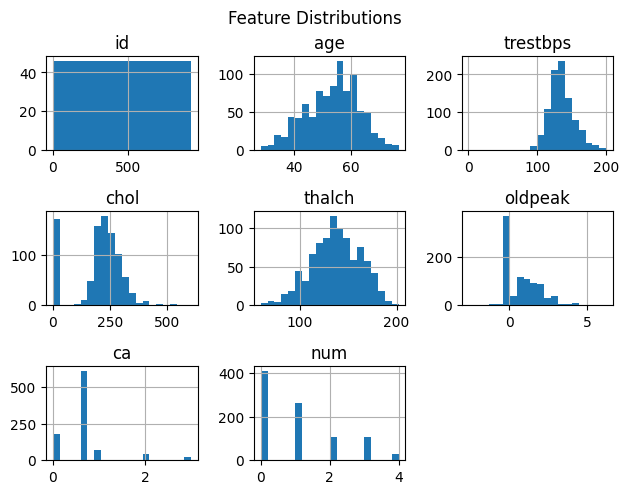

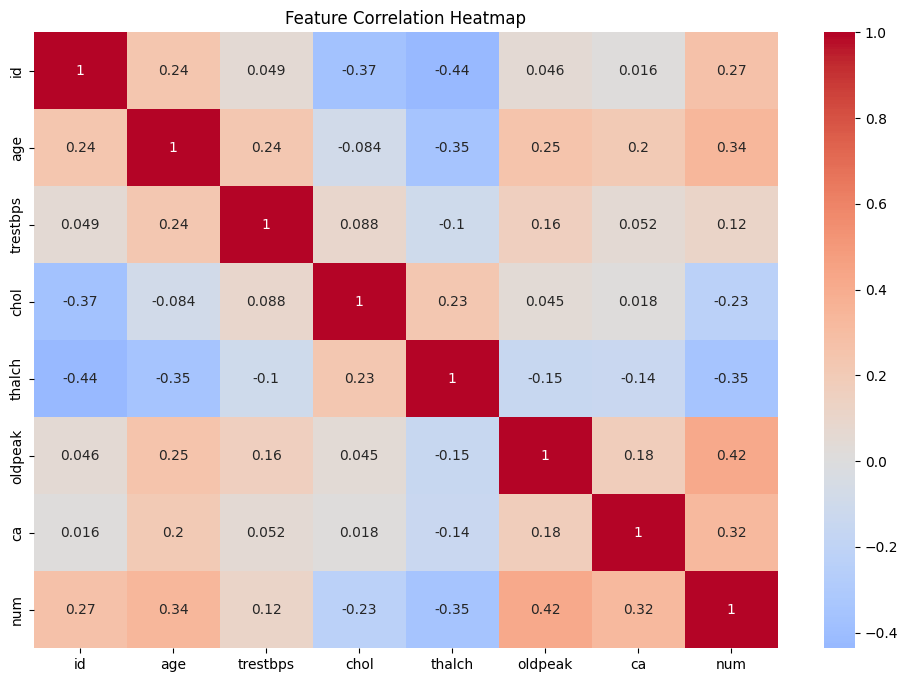

✅ Features prepared: 30 features
🎯 Target distribution: {1: 509, 0: 411}
🤖 Training machine learning models...

🔄 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.842, ROC-AUC: 0.913

📊 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        75
           1       0.88      0.85      0.87       109

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



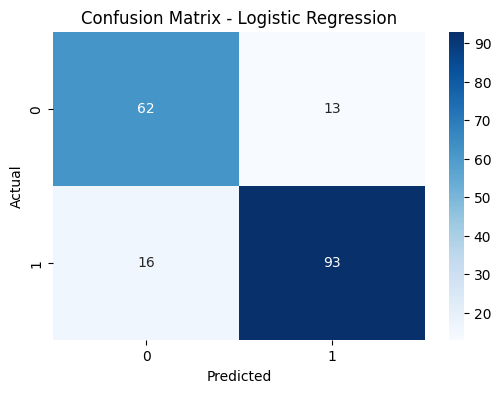


🔄 Training Random Forest...
✅ Random Forest - Accuracy: 0.886, ROC-AUC: 0.950

📊 Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        75
           1       0.92      0.89      0.90       109

    accuracy                           0.89       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



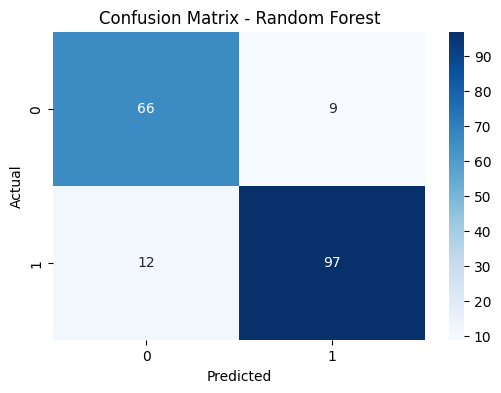


🔄 Training Decision Tree...
✅ Decision Tree - Accuracy: 0.815, ROC-AUC: 0.823

📊 Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        75
           1       0.89      0.78      0.83       109

    accuracy                           0.82       184
   macro avg       0.81      0.82      0.81       184
weighted avg       0.83      0.82      0.82       184



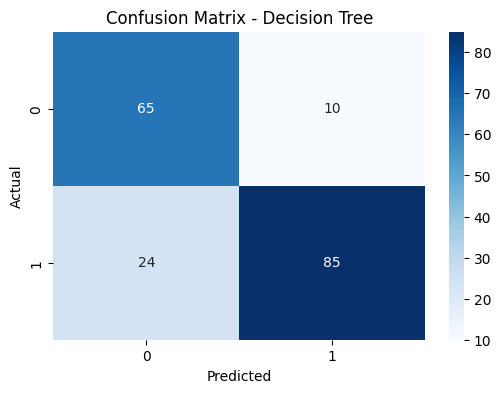

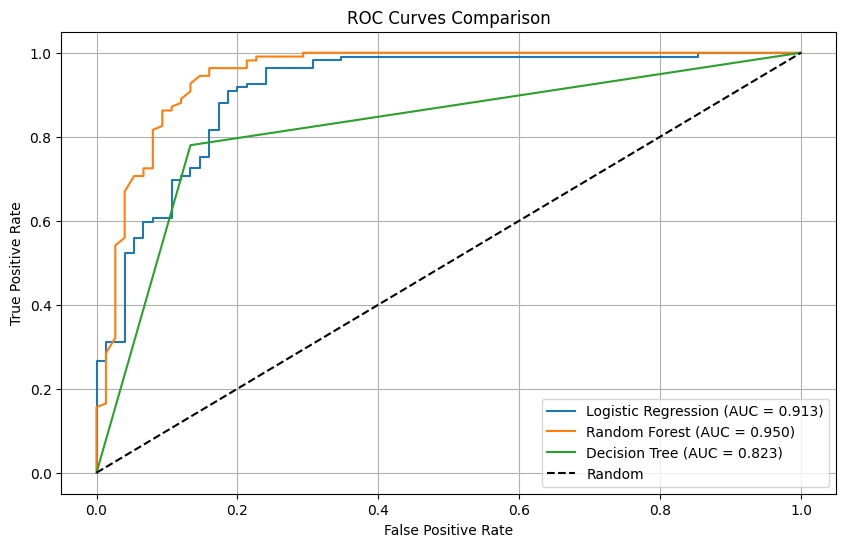

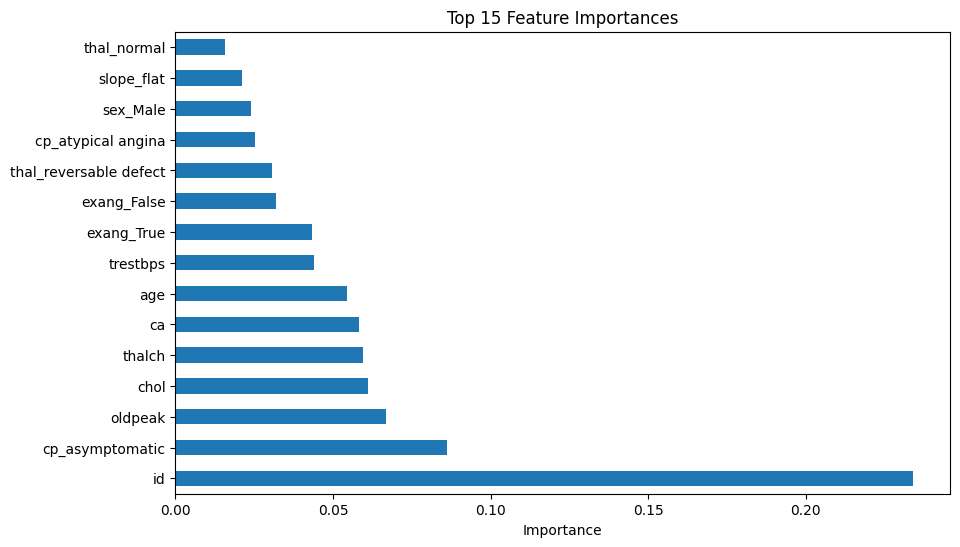


🏆 Best model saved: RandomForestClassifier with 0.886 accuracy

📊 MODEL PERFORMANCE SUMMARY
Logistic Regression  | Accuracy: 0.842 | ROC-AUC: 0.913
Random Forest        | Accuracy: 0.886 | ROC-AUC: 0.950
Decision Tree        | Accuracy: 0.815 | ROC-AUC: 0.823

✅ Training completed! Models saved successfully.
🌐 Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d4800620e8101d881a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
if __name__ == "__main__":
    main()
